<h3 style="text-align:left">About my study</h3>
Here I implement an application of PCA where I compute eigengenes for both the training and test sets
to be representative of the gene expression profile for each assay in a lower dimensional subspace. 
7129 variables down to 28 and 24, for the training and test set, respectively. With a low dimension
of the gene expression data, I train various classifiers and evaulate its efficacy in predicting 
the cell cancer type on the testing set. A excellent study on Tuning Hyperparameters by Chris Hawford 
can be found 
<a href="https://www.kaggle.com/crawford/hyperparameter-search-comparison-grid-vs-random" target="_blank">here</a>.

<h3 style="text-align:left">The original study</h3>
From Golub et al., the data was derived from gene expression profiles of cancer cells with either acute 
lymphocytic leukemia (ALL) or acute myeloid leukemia (AML). The original study was published in 1999
and it was landmark research because it was the first to show that cancer type could be classified 
based solely of gene expression data.

<h3 style="text-align:left">The data</h3>
<ul>
    <li> Genes are on rows
    <li> Patients are on columns
    <li> The expression of 7129 genes were analyzed per patient
</ul>

<h4 style="text-align:left">Data uploading and cleaning</h4>

In [2]:
#Import packages and dependencies
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from numpy import linalg
from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.patches as mpatches

In [3]:
#Import raw data
train_raw = pd.read_csv("./data_set_ALL_AML_train.csv").drop(['Gene Description','Gene Accession Number'],axis=1)
test_raw = pd.read_csv("./data_set_ALL_AML_independent.csv").drop(['Gene Description','Gene Accession Number'],axis=1)
y_train = list(pd.read_csv("actual.csv")['cancer'][:38])
y_test = list(pd.read_csv("actual.csv")['cancer'][38:])

#Clean raw data
train_data = pd.DataFrame(train_raw[[col for col in train_raw.columns if "call" not in col]])
test_data = pd.DataFrame(test_raw[[col for col in test_raw.columns if "call" not in col]])
y_train = [0 if x == "ALL" else 1 for x in y_train]
y_test = [0 if x == "ALL" else 1 for x in y_test]

<h4 style="text-align:left">Eigengene Analysis on the training set utilizing principle component analysis</h4>

In [4]:
class PCA:
    '''
    Class performs principle component analysis
    Stores explained variance and cumalative sum of variance
    '''
    def __init__(self, data,mean):
        self.mean_gene = mean
        #Initialize data matrix
        self.data = self.normalize(data)
        #Initialize dimensions of data matrix, m observations on p variables
        [self.m,self.p] = self.data.shape
        #Initialize array to store the variance and sum of variance
        self.explained_variance = []
        self.cumsum = []
        
    def normalize(self,X):
        #Column center the data matrix X
        #In this case, subtracts the mean gene expression from each assay
        i,j = X.shape
        return X - np.outer(self.mean_gene, np.ones(j))
    
    def SVD(self,X):
        #Method returns the singular value decomposition of a data matrix
        [U,S,V] = np.linalg.svd(X,full_matrices=False)
        #Compute the explained variance derived from the SVD
        var_sum = sum(S)
        self.explained_variance = S/var_sum*100
        #Compute the comulative sum derived from the SVD
        self.cumsum = np.cumsum(self.explained_variance)
        return U,S,normalize(V.T,axis=0)
    
    def PC(self,X):
        #Method returns the principle component projection of the data matrix
        [U,S,V] = self.SVD(X)
        return normalize(np.dot(X,V.T),axis=0)

In [5]:
#Initialize PCA object with training data and mean gene expression
trainPCA = PCA(train_data,train_data.mean(1))

In [6]:
#Acquire the low dimensional projection in eigenspace of the training data
PC = trainPCA.PC(trainPCA.data)
U,S,V = trainPCA.SVD(trainPCA.data)

<h3 style="text-align:left">Training set eigengene visualization</h3>

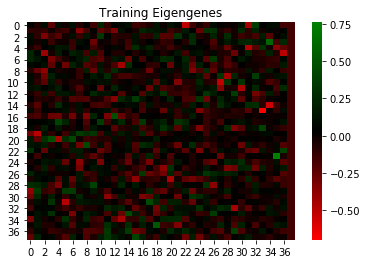

In [7]:
cmap=LinearSegmentedColormap.from_list('rg',["r", "black", "g"], N=256) 
ax = sns.heatmap(V,cmap=cmap)
plt.title('Training Eigengenes')
plt.show()

<h3 style="text-align:left">2D and 3D training set eigengenes</h3>

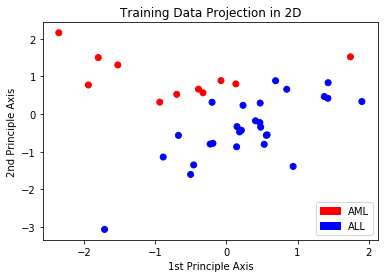

In [16]:
#Plot of individual assays in 2-dimensional eigenspace
%matplotlib inline
scaler = StandardScaler()
scaler.fit(V)
V = scaler.transform(V)
colors = ['red', 'blue']
levels = [0, 1]
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, colors=colors, extend='max')
plt.scatter(V[:,0],V[:,1],c=y_train,cmap=cm.bwr)
plt.title("Training Data Projection in 2D")
plt.xlabel("1st Principle Axis")
plt.ylabel("2nd Principle Axis")
red_patch = mpatches.Patch(color='red', label='AML')
blue_patch = mpatches.Patch(color='blue', label='ALL')
plt.legend(handles=[red_patch,blue_patch])
plt.show()

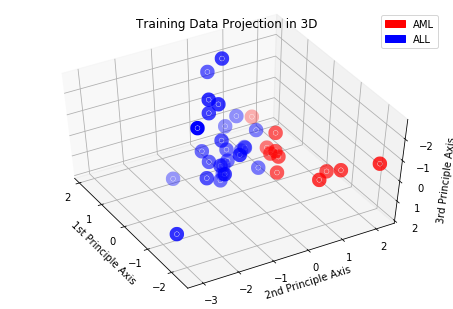

In [17]:
#Plot of individual assays in 3-dimensional eigenspace
%matplotlib inline
colors = ['red', 'blue']
levels = [0, 1]
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, colors=colors, extend='max')
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-130, azim=30,)
ax.scatter(V[:,0], V[:,1], V[:,2], c=y_train,cmap=cm.bwr,linewidths=10)
ax.set_title("Training Data Projection in 3D")
ax.set_xlabel("1st Principle Axis")
ax.set_ylabel("2nd Principle Axis")
ax.set_zlabel("3rd Principle Axis")
ax.legend(handles=[red_patch,blue_patch])
plt.show()

<h3 style="text-align:left">Eigengene analysis on the testing data</h3>

In [18]:
#Determine the low dimension representation of the testing data
testnorm = test_data - np.outer(train_data.mean(1), np.ones(34))
#This is accomplished by projecting the testing data in the eigenspace of the training eigengenes
W = np.dot(testnorm.T,PC)
W = normalize(W,axis=0)

<h3 style="text-align:left">Testing set eigengene visualization</h3>

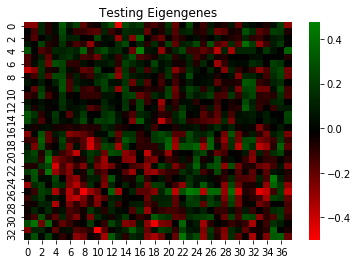

In [514]:
cmap=LinearSegmentedColormap.from_list('rg',["r", "black", "g"], N=256) 
ax = sns.heatmap(W,cmap=cmap)
plt.title('Testing Eigengenes')
plt.show()

<h3 style="text-align:left">2D and 3D plots for the test set eigengenes</h3>

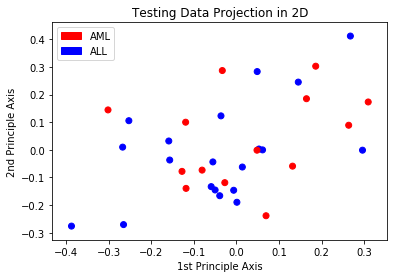

In [19]:
%matplotlib inline
colors = ['red', 'blue']
levels = [0, 1]
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, colors=colors, extend='max')
plt.scatter(W[:,0],W[:,1],c=y_test,cmap=cm.bwr)
plt.title("Testing Data Projection in 2D")
plt.xlabel("1st Principle Axis")
plt.ylabel("2nd Principle Axis")
red_patch = mpatches.Patch(color='red', label='AML')
blue_patch = mpatches.Patch(color='blue', label='ALL')
plt.legend(handles=[red_patch,blue_patch])
plt.show()

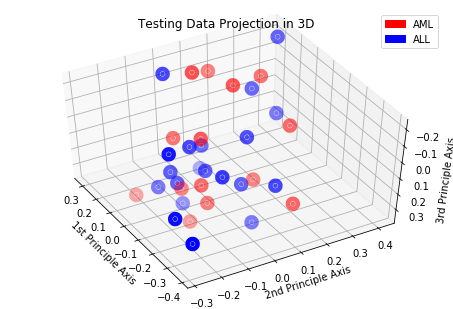

In [20]:
%matplotlib inline
plt.clf()
colors = ['red', 'blue']
levels = [0, 1]
cmap, norm = mpl.colors.from_levels_and_colors(levels=levels, colors=colors, extend='max')
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-130, azim=30,)
ax.scatter(W[:,0],W[:,1],W[:,2], c=y_test,cmap=cm.bwr,linewidths=10)
ax.set_title("Testing Data Projection in 3D")
ax.set_xlabel("1st Principle Axis")
ax.set_ylabel("2nd Principle Axis")
ax.set_zlabel("3rd Principle Axis")
ax.legend(handles=[red_patch,blue_patch])
plt.show()

<h3 style="text-align:left">Classifier Comparison</h3>
Utilized Classifiers:
<ul>
    <li>Neural Network 
    <li>Decision Tree
    <li>Logistic Regression
    <li>Random Forest
    <li> Support Vector Machine
    <li> Non-linear Support Vector Machine
</ul>

In [517]:
#Neural Network
mlp = MLPClassifier(solver='lbfgs', alpha=1e-9,hidden_layer_sizes=(38, 10), random_state=4)
mlp.fit(V, y_train)
print("Accuracy on training set: {:.2f}".format(mlp.score(V, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(W, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.68


In [518]:
confusion_matrix(y_test, mlp.predict(W))

array([[19,  1],
       [10,  4]], dtype=int64)

In [519]:
#Decision Tree
tr = DecisionTreeClassifier(random_state=15).fit(V,y_train)
print("Accuracy on training set: {:.2f}".format(tr.score(V, y_train)))
print("Accuracy on test set: {:.2f}".format(tr.score(W, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.65


In [520]:
confusion_matrix(y_test, tr.predict(W))

array([[17,  3],
       [ 9,  5]], dtype=int64)

In [521]:
#Logistic Regression
logreg = LogisticRegression().fit(V,y_train)
print("Accuracy on training set: {:.2f}".format(logreg.score(V, y_train)))
print("Accuracy on test set: {:.2f}".format(logreg.score(W, y_test)))

Accuracy on training set: 0.71
Accuracy on test set: 0.59


In [522]:
confusion_matrix(y_test, logreg.predict(W))

array([[20,  0],
       [14,  0]], dtype=int64)

In [523]:
#Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=14)
rf.fit(V, y_train)
print("Accuracy on training set: {:.2f}".format(rf.score(V, y_train)))
print("Accuracy on test set: {:.2f}".format(rf.score(W, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.68


In [524]:
confusion_matrix(y_test, rf.predict(W))

array([[19,  1],
       [10,  4]], dtype=int64)

In [530]:
#Support Vector Machine
svc = svm.SVC()
svc.fit(V, y_train)
print("Accuracy on training set: {:.2f}".format(svc.score(V, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(W, y_test)))

Accuracy on training set: 0.71
Accuracy on test set: 0.59


In [526]:
confusion_matrix(y_test, svc.predict(W))

array([[20,  0],
       [14,  0]], dtype=int64)

In [527]:
#Non-linear Support Vector Machine
nsvc = svm.NuSVC().fit(V,y_train)
print("Accuracy on training set: {:.2f}".format(nsvc.score(V, y_train)))
print("Accuracy on test set: {:.2f}".format(nsvc.score(W, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.62


In [528]:
confusion_matrix(y_test, nsvc.predict(W))

array([[18,  2],
       [11,  3]], dtype=int64)